In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import duckdb
import os
import glob
import matplotlib.pyplot as plt
import json
from tabulate import tabulate
from pathlib import Path
import seaborn as sns
from IPython.display import display

In [2]:
def gini(array):
    
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    
    assert np.min(array) > 0
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))


In [3]:
mlhd_path = '../data/mlhd/*/*.parquet'
musicbrainz_path = '../data/musicbrainz.db'
stat_path = 'outputs'

conn = duckdb.connect()
# conn.execute("SHOW TABLES").fetchall()
# conn.execute("DROP TABLE IF EXISTS mlhd_main")

# MusicBrainz Data
#### Let's do a quick exploration of the MusicBrainz data and its structure.

In [4]:
brainz_conn = duckdb.connect(musicbrainz_path)
brainz_conn.execute("SHOW TABLES").fetchall()

[('mb_artist',), ('mb_recording',)]

In [5]:
brainz_conn.execute("SELECT * FROM mb_artist LIMIT 5").fetchdf()

,artist_id,name,gender,type
0,7f1271e5-cbfc-4ef5-8077-7c7181b6cafd,Bricklin,None,Group
1,14ac1236-3cb6-4c02-be83-e4949d59e26f,Monkey House,None,Group
2,7e987529-210e-4c5e-b344-15cfb7349307,Soda,None,Group
3,d2674f9b-c46c-40ae-9b52-b753d19a2021,Blood or Whiskey,None,Group
4,a81f7041-7cd7-4080-ba88-9ce5fe50dc19,Mint Condition,None,Group


In [6]:
brainz_conn.execute("SELECT * FROM mb_recording LIMIT 5").fetchdf()

,rec_id,title,artist_credit
0,10b9c34b-821d-4cc8-9587-5c7d0cb68865,Suck,"[{""joinphrase"":"""",""artist"":{""aliases"":[],""disa..."
1,f28b2394-bd5d-4f0c-a0de-55ce015a5c57,Whispering Shadows,"[{""joinphrase"":"""",""artist"":{""aliases"":[{""end"":..."
2,565de6d8-f93f-4b44-97e2-c1f3ffc2410a,The Calling,"[{""joinphrase"":"""",""artist"":{""aliases"":[],""disa..."
3,b26c15bd-9e01-4bc7-8bb0-63f58baa739b,Kiss-A-Me Baby,"[{""joinphrase"":"""",""artist"":{""aliases"":[{""end"":..."
4,192e313b-703b-456d-9143-bb7fa1f9dab1,I'll Never Get Out of These Blues Alive,"[{""joinphrase"":"""",""artist"":{""aliases"":[{""end"":..."


In [7]:
brainz_conn.execute("DESCRIBE SELECT * FROM mb_recording").fetchall()

[('rec_id', 'UUID', 'YES', None, None, None),
 ('title', 'VARCHAR', 'YES', None, None, None),
 ('artist_credit', 'JSON', 'YES', None, None, None)]

In [8]:
# retrieve artist_credit data from musicbrainz in JSON format
artist_credit = brainz_conn.execute("SELECT artist_credit FROM mb_recording LIMIT 5").fetchdf()
# for idx, value in artist_credit['artist_credit'].items():
#     parsed = json.loads(value)  
#     print(f"Row {idx}:\n{json.dumps(parsed, indent=4)}\n")

#### We plot the distribution of artist types (e.g., person, group, etc.) in MusicBrainz.

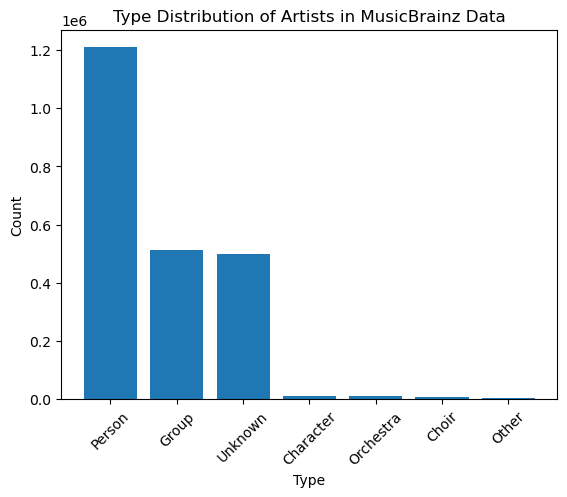

In [9]:
# plot artist type distribution
type_counts = brainz_conn.execute("SELECT type, COUNT(*) as count FROM mb_artist GROUP BY type ORDER BY count DESC").fetchdf()
type_counts['type'] = type_counts['type'].fillna('Unknown')

plt.bar(type_counts['type'], type_counts['count'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Type Distribution of Artists in MusicBrainz Data')
plt.xticks(rotation=45)
plt.show()

In [10]:
# number of records in mb_artist table of musicbrainz
brainz_conn.execute("SELECT COUNT(DISTINCT artist_id) AS distinct_count,COUNT(*) AS total_count FROM mb_artist").fetchall()

[(2251598, 2251598)]

# MLHD+ Data

### Metric Naming Conventions

- **User Count**: the number of **unique users** who have interacted with an entity.
  
- **Play Count**: the total number of **interactions** a user has had with an entity.

#### Now, let's take a look at the MLHD+ data structure.

In [11]:
conn.execute(f"DESCRIBE SELECT * FROM read_parquet('{mlhd_path}')").fetchall()

[('user_id', 'UUID', 'YES', None, None, None),
 ('timestamp', 'BIGINT', 'YES', None, None, None),
 ('artist_ids', 'UUID[]', 'YES', None, None, None),
 ('release_id', 'UUID', 'YES', None, None, None),
 ('rec_id', 'UUID', 'YES', None, None, None)]

#### Let's look at the unique counts of all entities in MLHD:

In [12]:
query = f"SELECT * FROM read_parquet('{stat_path}/unique_counts.parquet')"
unique_counts = conn.execute(query).fetchdf()

unique_counts.columns = ['Tracks (rec_id)', 'Artists (artist_id)', 'Releases (release_id)', 'Users (user_id)']
unique_counts = unique_counts.map(lambda x: f"{x:,}")

print('Unique count of tracks, artists, albums and users:\n')
display(unique_counts)

Unique count of tracks, artists, albums and users:



,Tracks (rec_id),Artists (artist_id),Releases (release_id),Users (user_id)
0,"6,685,542","490,765","944,679","594,415"


## Artist Popularity
#### We plot the rank-frequency distribution for artist popularity by total plays (play count) and unique users who interacted with them (user count). <br><br>For group-type artists, we consider all members in all our analyses.

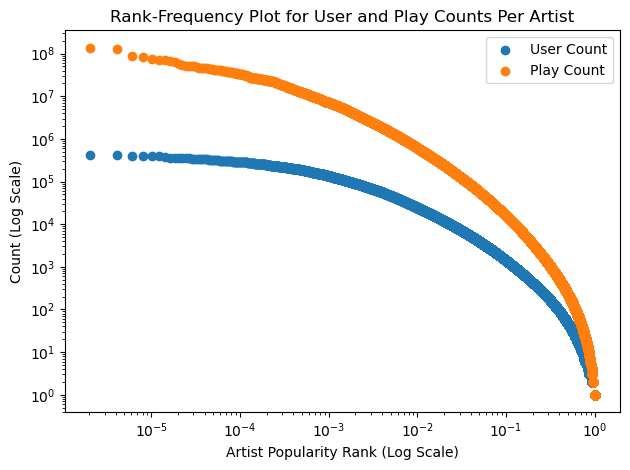

In [13]:
# plot artist popularity distribution
query = f"SELECT * FROM read_parquet('{stat_path}/artist_count.parquet')"
artist_count = conn.execute(query).fetchdf()

# calculate fractional artist ranks (rank/n)
artist_count['rank_inplay'] = artist_count['n_plays'].rank(method='max', ascending=False) / len(artist_count)
artist_count['rank_inuser'] = artist_count['n_users'].rank(method='max', ascending=False) / len(artist_count)

# plot the rank-frequency scatter plot with log scaling on both axes
fig, ax = plt.subplots()

ax.scatter(artist_count['rank_inuser'], artist_count['n_users'], label='User Count')
ax.scatter(artist_count['rank_inplay'], artist_count['n_plays'], label='Play Count')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Artist Popularity Rank (Log Scale)')
ax.set_ylabel('Count (Log Scale)')
ax.set_title('Rank-Frequency Plot for User and Play Counts Per Artist')
ax.legend()

plt.tight_layout()
plt.show()

## Artist Gender
#### Let's examine the distribution of gender groups by play count and user count.

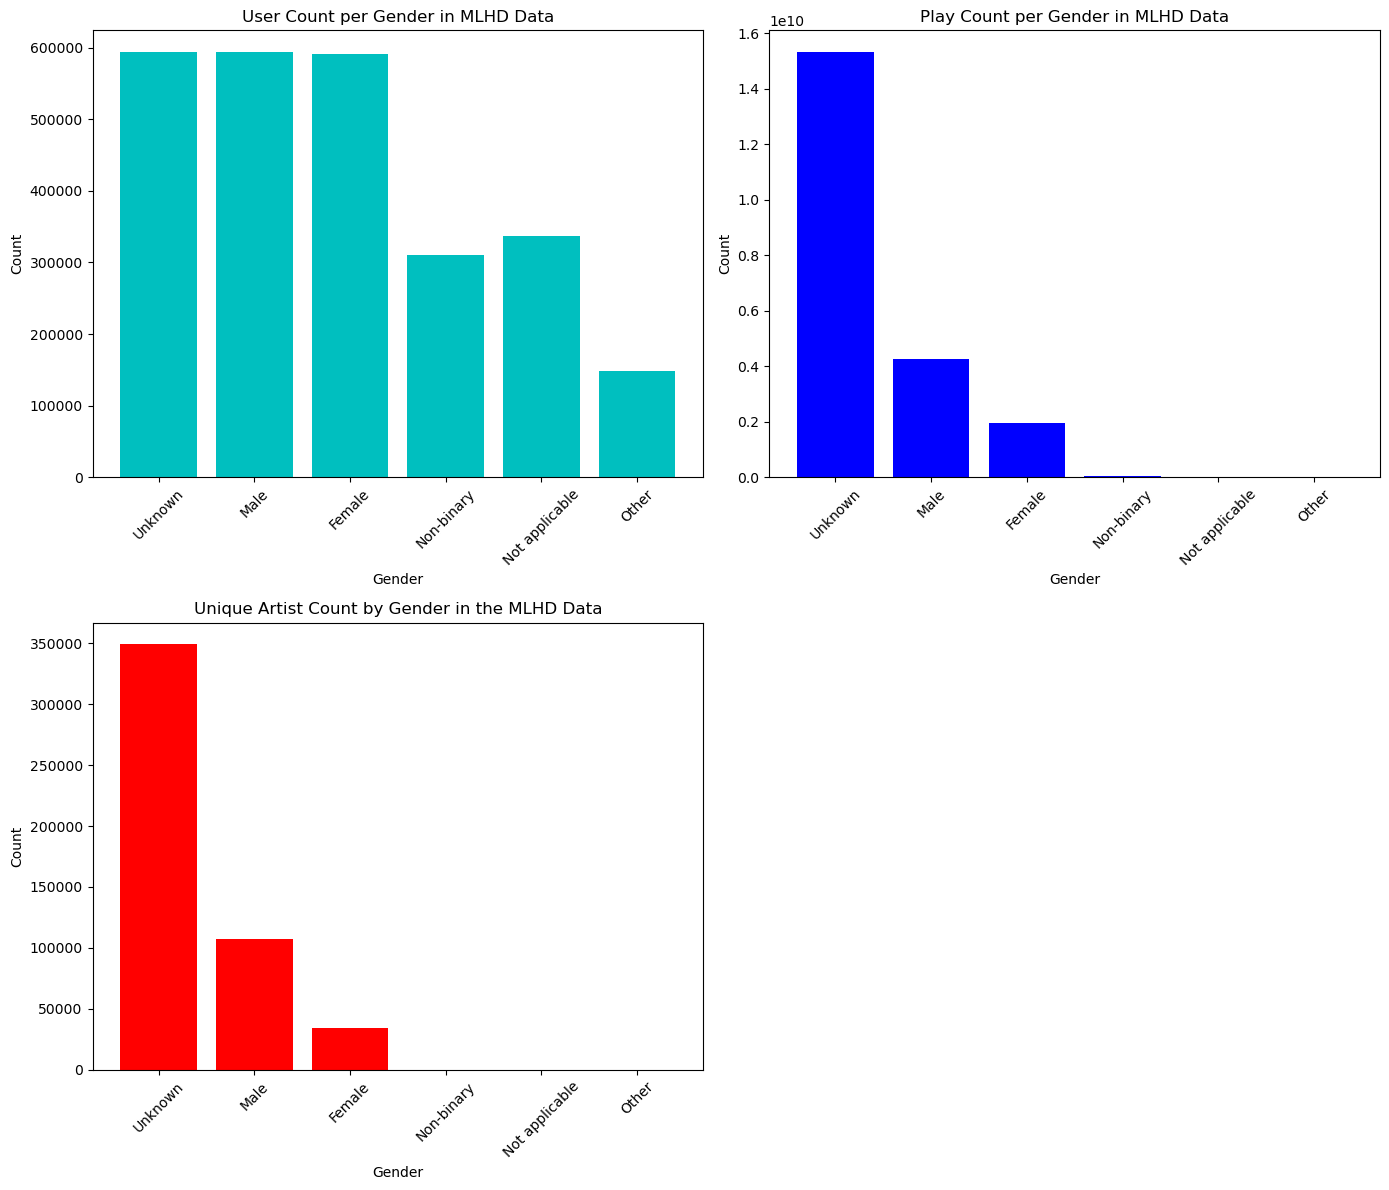

In [14]:
#plot gender distribution
query = f"SELECT * FROM read_parquet('{stat_path}/gender_count.parquet')"
gender_count = conn.execute(query).fetchdf()
gender_count['gender'] = gender_count['gender'].fillna('Unknown')

fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2, figsize=(14, 12)) 

ax1.bar(gender_count['gender'], gender_count['n_users'], color='c')  
ax1.set_title("User Count per Gender in MLHD Data")
ax1.set_xlabel("Gender")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

ax2.bar(gender_count['gender'], gender_count['n_plays'], color='b') 
ax2.set_title("Play Count per Gender in MLHD Data")
ax2.set_xlabel("Gender")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=45)

ax3.bar(gender_count['gender'], gender_count['unique_count'], color='r') 
ax3.set_title("Unique Artist Count by Gender in the MLHD Data")
ax3.set_xlabel("Gender")
ax3.set_ylabel("Count")
ax3.tick_params(axis='x', rotation=45)
_.axis('off')

plt.tight_layout()  
plt.show()

#### Let's examine gender distribution across active users (with >= 5 plays).

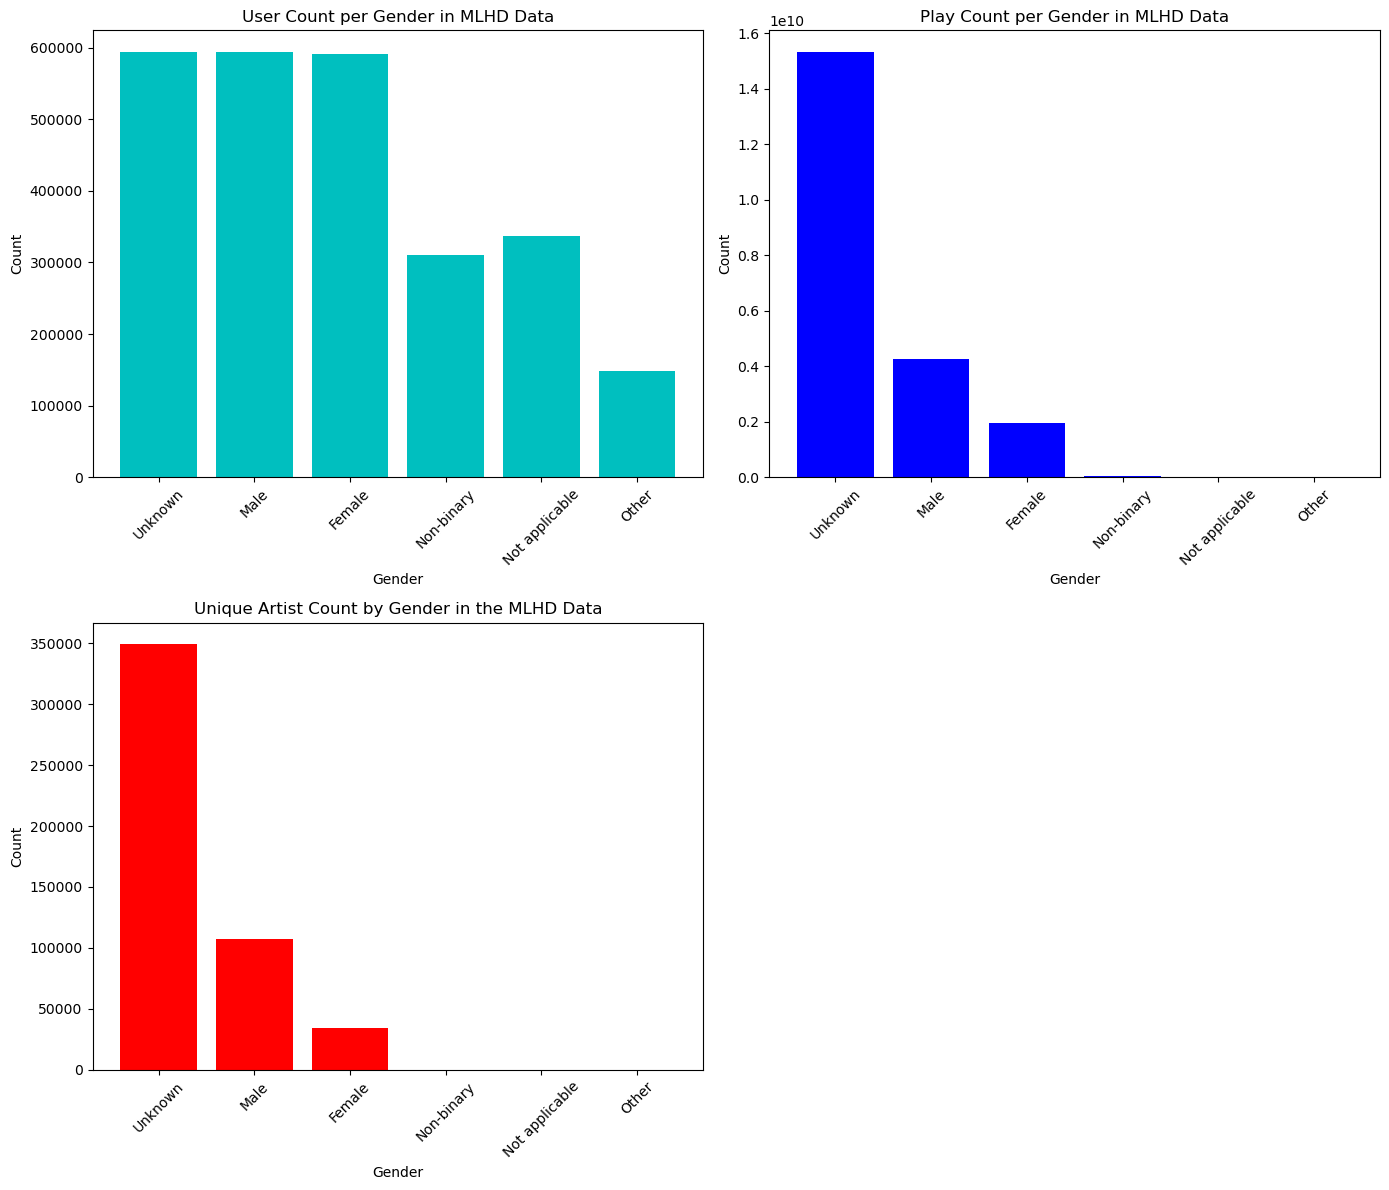

In [15]:
# plot gender distribution of artists in active users' data (with >=5 plays)
query = f"SELECT * FROM read_parquet('{stat_path}/gender_count_active.parquet')"
gender_count_active = conn.execute(query).fetchdf()
gender_count_active['gender'] = gender_count_active['gender'].fillna('Unknown')

fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2, figsize=(14, 12)) 

ax1.bar(gender_count_active['gender'], gender_count_active['n_users'], color='c')  
ax1.set_title("User Count per Gender in MLHD Data")
ax1.set_xlabel("Gender")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

ax2.bar(gender_count_active['gender'], gender_count_active['n_plays'], color='b') 
ax2.set_title("Play Count per Gender in MLHD Data")
ax2.set_xlabel("Gender")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=45)

ax3.bar(gender_count_active['gender'], gender_count_active['unique_count'], color='r') 
ax3.set_title("Unique Artist Count by Gender in the MLHD Data")
ax3.set_xlabel("Gender")
ax3.set_ylabel("Count")
ax3.tick_params(axis='x', rotation=45)
_.axis('off')

plt.tight_layout()  
plt.show()

#### We exclude non-first artists for group-type artists in gender distribution plots

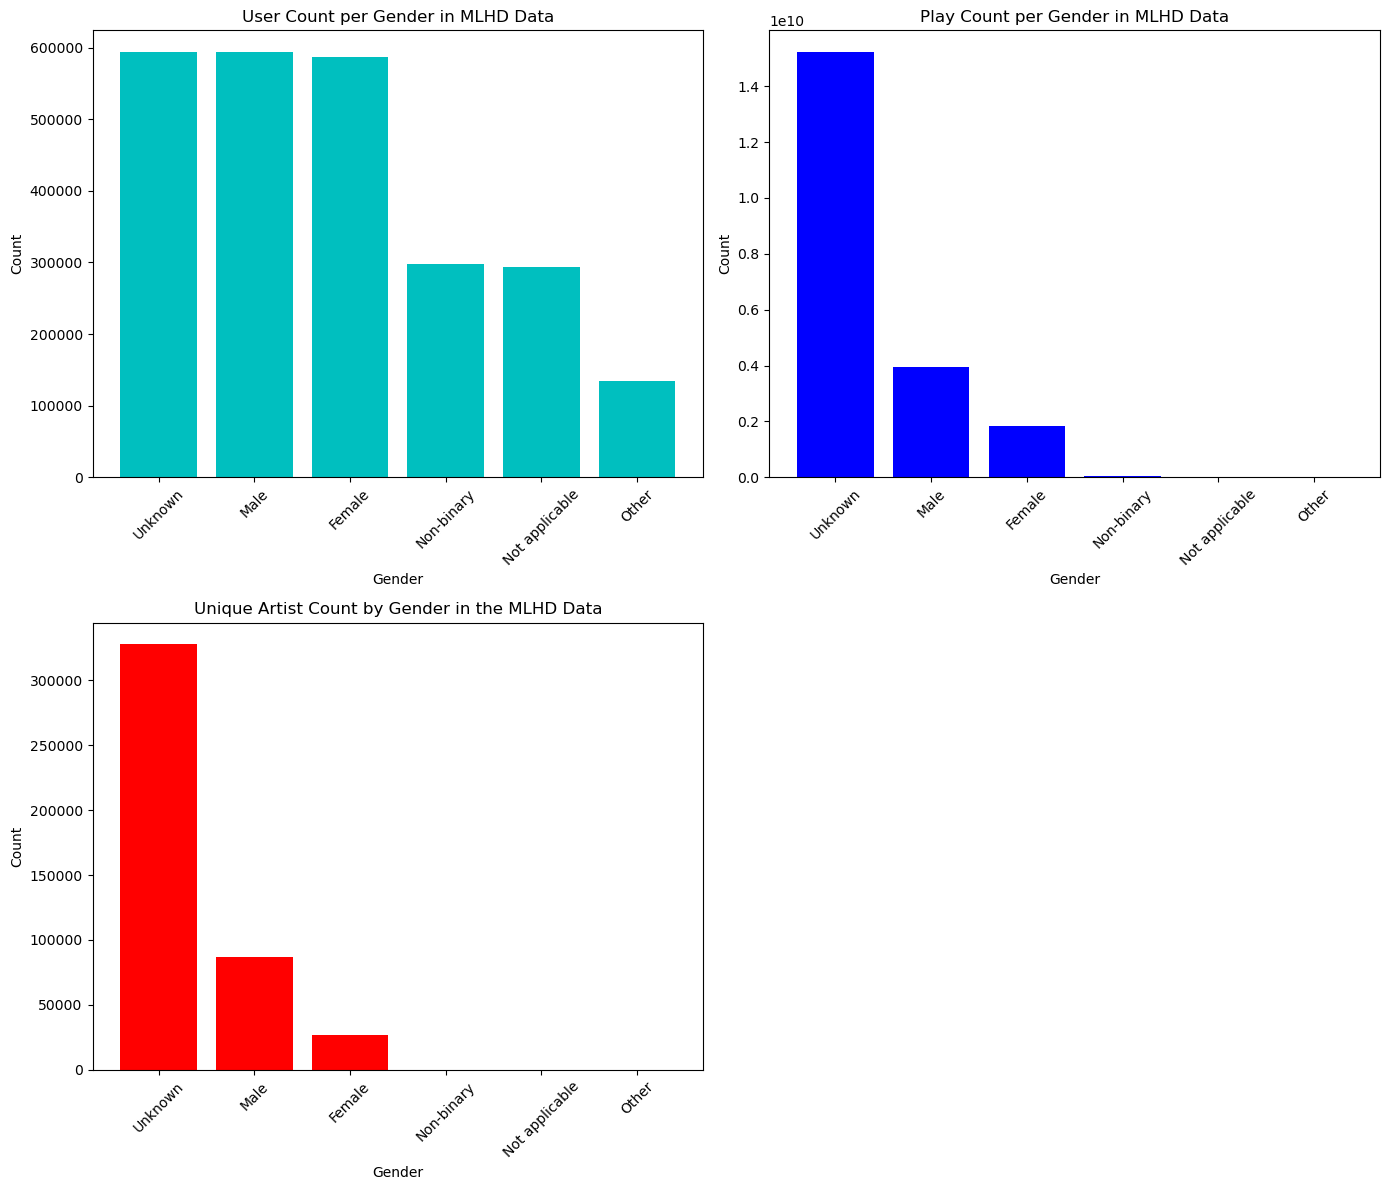

In [16]:
#plot gender distribution considering the first artist in group types
query = f"SELECT * FROM read_parquet('{stat_path}/gender_count_first.parquet')"
gender_count_first = conn.execute(query).fetchdf()
gender_count_first['gender'] = gender_count_first['gender'].fillna('Unknown')

fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2, figsize=(14, 12)) 

ax1.bar(gender_count_first['gender'], gender_count_first['n_users'], color='c')  
ax1.set_title("User Count per Gender in MLHD Data")
ax1.set_xlabel("Gender")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

ax2.bar(gender_count_first['gender'], gender_count_first['n_plays'], color='b') 
ax2.set_title("Play Count per Gender in MLHD Data")
ax2.set_xlabel("Gender")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=45)

ax3.bar(gender_count_first['gender'], gender_count_first['unique_count'], color='r') 
ax3.set_title("Unique Artist Count by Gender in the MLHD Data")
ax3.set_xlabel("Gender")
ax3.set_ylabel("Count")
ax3.tick_params(axis='x', rotation=45)
_.axis('off')

plt.tight_layout()  
plt.show()

## Music Release
#### We calculate the Gini coefficient for play counts and user counts across music releases to see how popularity is distributed among releases.

In [17]:
# Gini Index of unique users and play counts for releases
query = f"SELECT * FROM read_parquet('{stat_path}/release_count.parquet')"
release_count = conn.execute(query).fetchdf()
print("Gini coefficient for user count :", gini(release_count['n_users']))
print("Gini coefficient for play count:", gini(release_count['n_plays']))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Gini coefficient for user count : 0.8811458734141489
Gini coefficient for play count: 0.9367042176392512


#### Let's also plot the rank-frequency distribution for play counts and user counts per release.

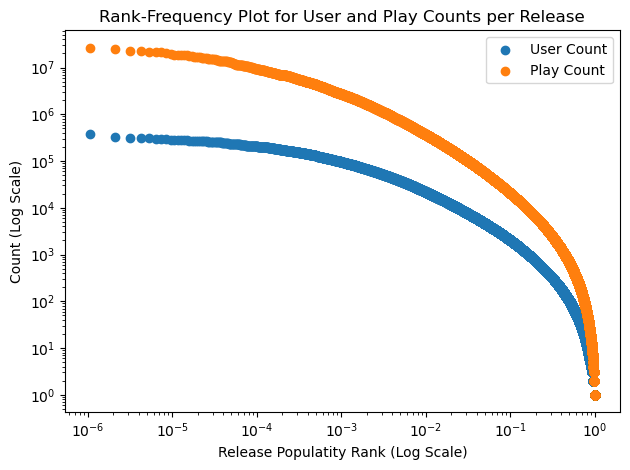

In [18]:
# calculate fractional release ranks (rank/n)
release_count['rank_inuser'] = release_count['n_users'].rank(method='max', ascending=False) / len(release_count)
release_count['rank_inplay'] = release_count['n_plays'].rank(method='max', ascending=False) / len(release_count)

fig, ax = plt.subplots()

ax.scatter(release_count['rank_inuser'], release_count['n_users'], label='User Count')
ax.scatter(release_count['rank_inplay'], release_count['n_plays'], label='Play Count')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Release Populatity Rank (Log Scale)')
ax.set_ylabel('Count (Log Scale)')
ax.set_title('Rank-Frequency Plot for User and Play Counts per Release')
ax.legend()


plt.tight_layout()
plt.show()

## Artist Type
#### We examine artist type distribution by play count and user count.

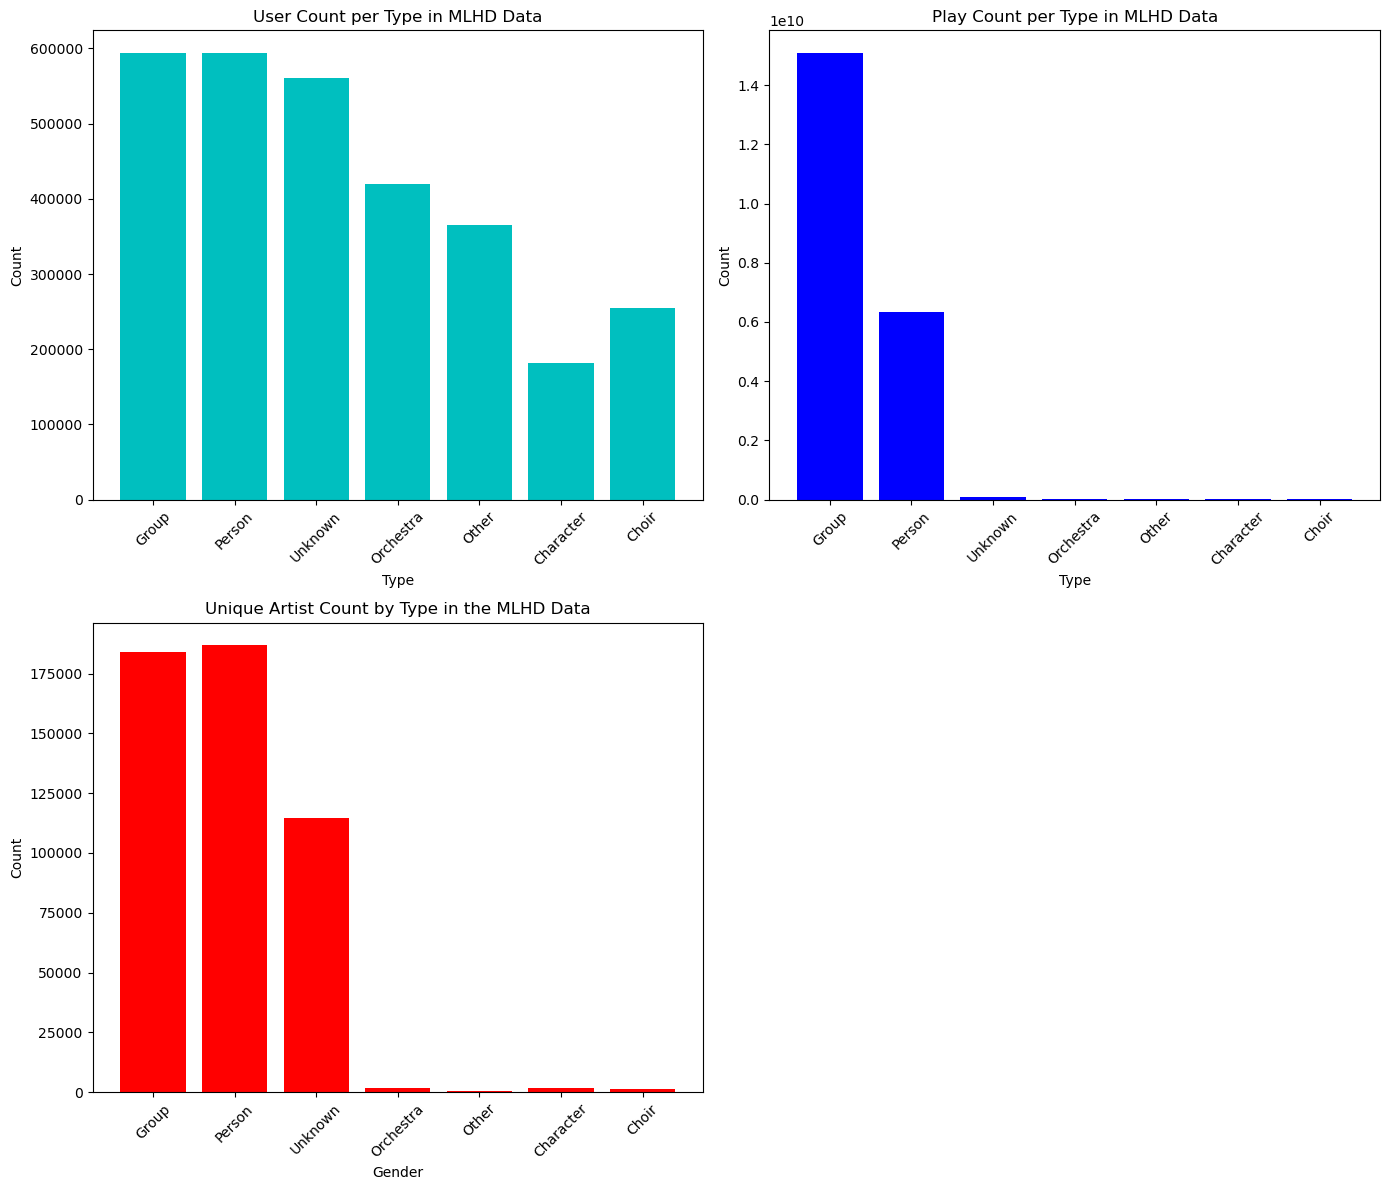

In [19]:
# plot popularity distribution over types
query = f"SELECT * FROM read_parquet('{stat_path}/type_count.parquet')"
type_count = conn.execute(query).fetchdf()
type_count['type'] = type_count['type'].fillna('Unknown')

fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2, figsize=(14, 12)) 

ax1.bar(type_count['type'], type_count['n_users'], color='c')  
ax1.set_title("User Count per Type in MLHD Data")
ax1.set_xlabel("Type")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

ax2.bar(type_count['type'], type_count['n_plays'], color='b') 
ax2.set_title("Play Count per Type in MLHD Data")
ax2.set_xlabel("Type")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=45)

ax3.bar(type_count['type'], type_count['unique_count'], color='r') 
ax3.set_title("Unique Artist Count by Type in the MLHD Data")
ax3.set_xlabel("Gender")
ax3.set_ylabel("Count")
ax3.tick_params(axis='x', rotation=45)
_.axis('off')

plt.tight_layout()  
plt.show()

# Music Genre
#### Let's plot the rank-frequency distribution for play count and user count per genre, excluding the unknown genre group from the data.

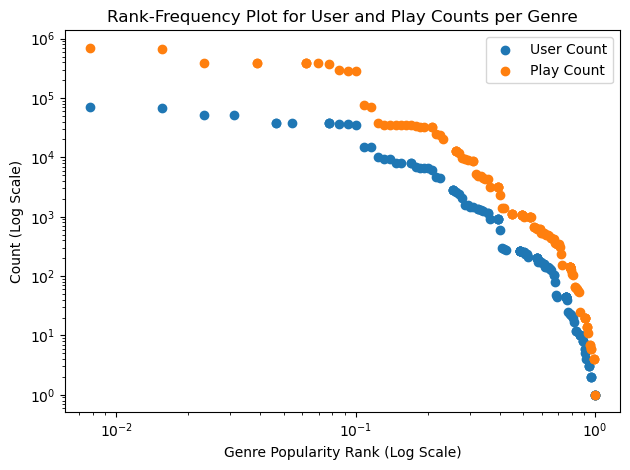

In [20]:
# plot popularity distribution over genres 
query = f"SELECT * FROM read_parquet('{stat_path}/genre_count.parquet')"
genre_count = conn.execute(query).fetchdf()
genre_count = genre_count.dropna(subset=['genre_name'])

# calculate fractional genre ranks (rank/n)
genre_count['rank_inuser'] = genre_count['n_users'].rank(method='max', ascending=False) / len(genre_count)
genre_count['rank_inplay'] = genre_count['n_plays'].rank(method='max', ascending=False) / len(genre_count)

fig, ax = plt.subplots()

ax.scatter(genre_count['rank_inuser'], genre_count['n_users'], label='User Count')
ax.scatter(genre_count['rank_inplay'], genre_count['n_plays'], label='Play Count')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Genre Popularity Rank (Log Scale)')
ax.set_ylabel('Count (Log Scale)')
ax.set_title('Rank-Frequency Plot for User and Play Counts per Genre')
ax.legend()


plt.tight_layout()
plt.show()

#### Top 5 most popular genres in MLHD based on user count:

In [21]:
top_unique_genres = genre_count.nlargest(5, 'n_users')
print('The 5 Most Frequent Genres in MLHD:\n\n', top_unique_genres[['genre_name', 'n_users']].to_string(index=False))

The 5 Most Frequent Genres in MLHD:

         genre_name  n_users
"alternative rock"    71366
      "indie rock"    68000
            "rock"    52610
       "hard rock"    51188
     "baroque pop"    37344


#### Top 5 most popular genres in MLHD based on play count:

In [22]:
top_nunique_genres = genre_count.nlargest(5, 'n_plays')
print('The 5 Most Played Genres in MLHD:\n\n', top_nunique_genres[['genre_name', 'n_plays']].to_string(index=False))

The 5 Most Played Genres in MLHD:

         genre_name  n_plays
"alternative rock"   704277
      "indie rock"   673977
       "soft rock"   391637
     "baroque pop"   391031
 "psychedelic pop"   391031


## Music Track (rec_id)
#### Let’s plot the rank-frequency distribution of play counts per track to see how popularity is spread across tracks.

In [23]:
# plot play count across tracks 
query = f"SELECT * FROM read_parquet('{stat_path}/track_count.parquet')"
track_count = conn.execute(query).fetchdf()
track_count.describe().round(2)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_plays
count,6685542.00
mean,3153.01
std,28784.98
min,1.00
25%,17.00
50%,111.00
75%,653.00
max,3920669.00


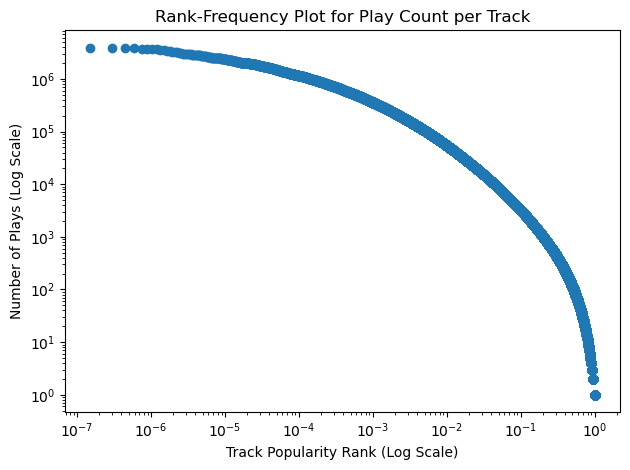

In [24]:
# calculate fractional track rank
track_count['rank'] = track_count['n_plays'].rank(method='max', ascending=False) / len(track_count)

fig, ax = plt.subplots()

ax.scatter(track_count['rank'], track_count['n_plays'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Track Popularity Rank (Log Scale)')
ax.set_ylabel('Number of Plays (Log Scale)')
ax.set_title('Rank-Frequency Plot for Play Count per Track')

plt.tight_layout()
plt.show()

## User Activity Level: Play Count per User
####  We plot a histogram showing the distribution of play counts (interactions) per user to examine the sparsity of interaction data across users.

In [25]:
# play count statistics across users
query = f"SELECT * FROM read_parquet('{stat_path}/play_count.parquet')"
play_count = conn.execute(query).fetchdf()
play_count.describe().round(2)

,play_count
count,594415.00
mean,35462.79
std,33272.65
min,3.00
25%,15792.00
50%,26269.00
75%,43951.00
max,892764.00


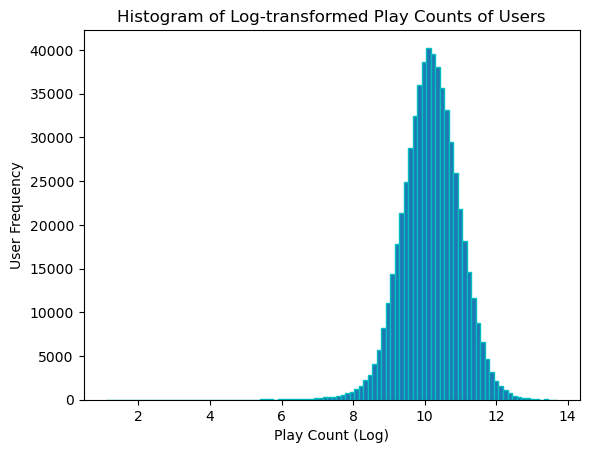

In [26]:
# Plot user play counts histogram
play_count['log_count'] = np.log(play_count['play_count'])
plt.hist(play_count['log_count'], bins=100, edgecolor='c')
plt.title('Histogram of Log-transformed Play Counts of Users')
plt.xlabel('Play Count (Log)') 
plt.ylabel('User Frequency')  
plt.show()